In [12]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd

from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra

pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/

In [13]:
%matplotlib notebook

In [14]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

In [15]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


In [16]:
def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo

# Select data set

In [17]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']

In [18]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [19]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print extr_traces.keys()
print extr_traces[extr_traces.keys()[0]].keys()


FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
12
12
12
12
[u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']


# Set output dir

In [20]:
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get stimulus info

In [21]:
def get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        print len(cycle_starts)
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []; cycle_indices = [];
        curr_roi_tracearray = roi_traces[curr_cond]
        for tix in np.arange(0, curr_roi_tracearray.shape[0]):

            roi_trace = curr_roi_tracearray[tix, :] #extr_traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces_currtrial = np.zeros((nparsed_cycles, fr_per_cycle))
            cindices_currtrial = np.zeros((nparsed_cycles, chunksize))
            cyc_counter = 0
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces_currtrial[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]
                cindices_currtrial[cycle, :] = stiminfo[curr_cond]['cycle_start_ixs'][cyc_counter:cyc_counter+chunksize]
                cyc_counter += chunksize
                
            roi_cycles.append(ptraces_currtrial)
            cycle_indices.append(cindices_currtrial)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = np.array(cycle_indices) #[s for s in cycle_starts] #[s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

# Parse cycles of each condition

In [22]:
c1 = 'right'
c2 = 'left'
c1_color = 'blue'
c2_color = 'orange'


### Look at 1 ROI first

In [23]:
rid = 27
plot_each_condition = False

roi_traces= dict()
for condition in trials_by_cond.keys():
    roi_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
    print"%s:" % condition, roi_traces[condition].shape

if plot_each_condition:
    pl.figure()
    for tr in np.arange(0, roi_traces[c1].shape[0]):
        pl.plot(roi_traces[c1][tr,:], 'k', lw=0.5, alpha=0.5)
    pl.plot(roi_traces[c1].mean(axis=0), 'k', lw=1, alpha=1)
    for cyc in stiminfo[c1]['cycle_start_ixs']:
        pl.axvline(x=cyc, color='r', lw=0.5)

top: (3, 4125)
right: (3, 4125)
left: (3, 4125)
bottom: (3, 4125)


### Get average N cycles

In [24]:
def plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs):

    fig, axes = pl.subplots(2,1)

    for axi, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[axi]

        # Plot FW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c1].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)   # Plot each "rep" of chunked cycle
        ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1) # Plot average chunked cycle
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c1].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs:
            ax.axvline(x=cyc, color='k', lw=0.5)       # Plot cycle start lines

        # Plot BW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c2].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
        ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c2].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs: #parsed_cycle_ixs[c2][0:chunksize]:
            ax.axvline(x=cyc, color='k', lw=0.5)
            
    return fig


#### Parse roi trace for each trial into N chunks

In [25]:
chunksize = 3
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)
print parsed_traces[c1].shape

4
4
4
4
(3, 4, 1029)


In [26]:
parsed_cycle_ixs[c1].mean(axis=0)

array([[    0.,   343.,   686.],
       [ 1029.,  1372.,  1715.],
       [ 2058.,  2401.,  2744.],
       [ 3087.,  3430.,  3773.]])

Saving ROI figures to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


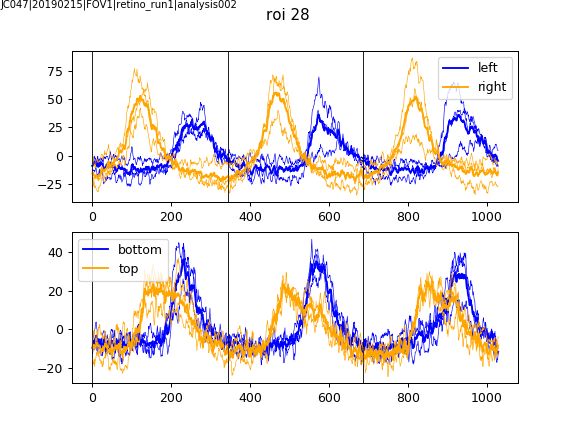

avg_3cycle_by_cond_roi00028


In [27]:
if not os.path.exists(os.path.join(output_dir, 'parsed_cycles_by_roi')):
    os.makedirs(os.path.join(output_dir, 'parsed_cycles_by_roi'))
print "Saving ROI figures to: %s" % os.path.join(output_dir, 'parsed_cycles_by_roi')

subcycle_ixs = stiminfo[c1]['cycle_start_ixs'][0:chunksize]

fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)

figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname


# Get bar positions from MW

In [28]:
# Interpolate bar position for found SI frame using upsampled MW tstamps and positions:


def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
    mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
    si_fps = stiminfo[condname]['frame_rate']
    print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

    si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
    si_tstamps = runinfo['frame_tstamps_sec']


    #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

    stim_pos_list = []
    stim_tstamp_list = []

    for ti, trial in enumerate(trials_by_cond[condname]):
        #ax = axes[ti]

        pos_list = []
        tstamp_list = []
        mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
        for cix in np.arange(0, len(mw_cyc_ixs)):
            if cix==len(mw_cyc_ixs)-1:
                mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
                xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
                si_ts = si_tstamps[si_cyc_ixs[cix]:]
            else:
                mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
                xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
                si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

            recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
            recentered_si_ts = [t-si_ts[0] for t in si_ts]

            # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
            interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
            resampled_xs = interpos(recentered_si_ts)

            pos_list.append(pd.Series(resampled_xs, name=trial))
            tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

            #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
            #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

        pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
        tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

        stim_pos_list.append(pos_vals)
        stim_tstamp_list.append(tstamp_vals)

    stim_positions = pd.concat(stim_pos_list, axis=1)
    stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


    return stim_positions, stim_tstamps


In [29]:
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

#stim_positions1, stim_tstamps1 = get_interp_positions(c1, mwinfo, stiminfo, trials_by_cond)
#stim_positions2, stim_tstamps2 = get_interp_positions(c2, mwinfo, stiminfo, trials_by_cond)

[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)


# Identify max, min, and "onset" frame in averaged trace

In [30]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    for cyc_ix, cyc_start in enumerate(cycle_starts):

        curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
        curr_values = avg_cycle_c1[curr_frames]
        cmax = int(np.where(curr_values==curr_values.max())[0][0])
        cmaxima.append((curr_frames[cmax], curr_values.max()))

        minval = curr_values[0:cmax].min()
        cmin = int(np.where(curr_values[0:cmax]==minval)[0][0])
        cminima.append((curr_frames[cmin], minval))

        baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
        bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
        if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
            if cyc_ix == 0:
                # No previous cycle to borrow frames from
                bindices = curr_frames[0:cmin+baseline_window_size]
                baseline = curr_values[0:cmin+baseline_window_size]
            else:
                prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                prev_values = avg_cycle_c1[prev_frames]
                nprev = baseline_window_size-cmin
                bindices = curr_frames[0:cmin] #+baseline_window_size]
                bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                baseline = prev_values[-nprev:]
                baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

        thr_value = baseline.std() * nstds_above_baseline #curr_values.max()*0.1
        onset = np.where(np.abs(curr_values[0:cmax]-thr_value)==np.min(np.abs(curr_values[0:cmax]-thr_value)))[0]

        onsets.append((curr_frames[onset], curr_values[onset]))
        baseline_values.append(baseline)
        baseline_indices.append(bindices)
        
    loci = {'maxima': cmaxima,
           'minima': cminima,
           'onsets': onsets,
           'baseline_indices': baseline_indices,
           'baseline_values': baseline_values,
           'nstds_above_baseline': nstds_above_baseline}
        
    return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)



In [31]:
def plot_cycle_loci(avg_cycle_c1, cycle_starts, loci, ax=None): #cmax, cmin, onsets, bas_ixs, bas_vals):

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3)) #pl.figure()

    ax.plot(avg_cycle_c1, color='k', lw=0.5)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color='k', linestyle='--', lw=0.5)

    for c in loci['maxima']:
        ax.plot(c[0], c[1], 'r.', markersize=10)

    for c in loci['minima']: #cmin:
        ax.plot(c[0], c[1], 'y.', markersize=10)

    for ons in loci['onsets']: #onsets:
        if not ons[0].size:
            continue
        ax.plot(ons[0], ons[1], 'g.',  markersize=10)

    for bi, bv in zip(loci['baseline_indices'], loci['baseline_values']): #bas_ixs, bas_vals):
        ax.plot(bi, bv, 'b')
        
    return ax

### Plot averaged mini-trace, with key loci

<IPython.core.display.Javascript object>


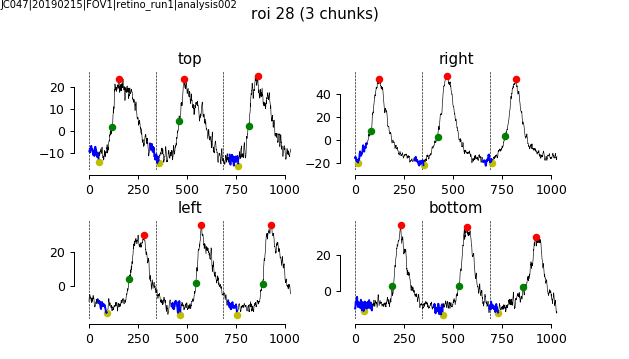

cycle_loci_3cycle_by_cond_roi00028


In [33]:
nstds_above_baseline = 1.5
window_nsecs = 1

fig, axes = pl.subplots(2, 2, figsize=(7,4)) #pl.figure()

loci = dict()
for aix, cond in enumerate(trials_by_cond.keys()):
    ax = axes.flat[aix]
    avg_cycle_c1 = parsed_traces[cond].mean(axis=1).mean(axis=0)
    cycle_starts = [int(c) for c in parsed_cycle_ixs[cond].mean(axis=0)[0,:]] #[0:chunksize]
    fr_per_cyc = stiminfo[cond]['n_frames_per_cycle'] 
    baseline_window_size = int(round(stiminfo[cond]['frame_rate']*window_nsecs))
    loci[cond] = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                                 baseline_window_size=baseline_window_size, 
                                                                 nstds_above_baseline=nstds_above_baseline)

    ax = plot_cycle_loci(avg_cycle_c1, cycle_starts, loci[cond], ax=ax)
    ax.set_title(cond)
    sns.despine(trim=True, offset=4, ax=ax)
    

fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))

pl.subplots_adjust(wspace=0.2, hspace=0.5, top=0.8)

label_figure(fig, data_identifier)


figname = 'cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname


# Use interp stim positions to get bar position at onset

In [34]:
# Use indices of parsed "cycle chunk" (should be nchunks=ncycles/chunksize 'traces' to match position to)

mean_pos_vals1 = stim_positions[c1].mean(axis=1)
avg_pos_list1 = []
cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[:, 0]] #[0:chunksize]
for cix, cyc in enumerate(cycle_starts):
    print cix, cyc
    if cix == len(cycle_starts)-1:
        avg_pos_list1.append(mean_pos_vals1[cyc:])
    else:
        avg_pos_list1.append(mean_pos_vals1[cyc:cycle_starts[cix+1]])
for ai, a in enumerate(avg_pos_list1):
    avg_pos_list1[ai] = a[0:stiminfo[c1]['n_frames_per_cycle']*chunksize]
    
mean_pos_vals2 = stim_positions[c2].mean(axis=1)
avg_pos_list2 = []
#cycle_starts = parsed_cycle_ixs[c2][0:chunksize]
cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[:, 0]] #[0:chunksize]
for cix, cyc in enumerate(cycle_starts):
    if cix == len(cycle_starts)-1:
        avg_pos_list2.append(mean_pos_vals2[cyc:])
    else:
        avg_pos_list2.append(mean_pos_vals2[cyc:cycle_starts[cix+1]])
    
for ai, a in enumerate(avg_pos_list2):
    avg_pos_list2[ai] = a[0:stiminfo[c2]['n_frames_per_cycle']*chunksize]
#avg_positions2 = np.vstack(avg_pos_list).mean(axis=0)



0 0
1 1029
2 2058
3 3087


In [35]:
# For each reptition of the "chunked cycle" find corresponding onset position:

onsets1 = loci[c1]['onsets']
onsets2 = loci[c2]['onsets']

onset_positions1 = []
onset_positions2 = []
nchunks = len(avg_pos_list1)
for onset, cyc, avg_pos in zip(onsets1, np.arange(0, nchunks), avg_pos_list1):
    onset_positions1.append(float(avg_pos.iloc[onset[0]]))

nchunks = len(avg_pos_list2)
for onset, cyc, avg_pos in zip(onsets2, np.arange(0, nchunks), avg_pos_list2):
    onset_positions2.append(float(avg_pos.iloc[onset[0]]))
    
onset_pos1 = np.mean(onset_positions1)
onset_pos2 = np.mean(onset_positions2)

print "%s: onset %.2f (std %.2f)" % (c1, onset_pos1, np.std(onset_positions1))
print "%s: onset %.2f (std %.2f)" % (c2, onset_pos2, np.std(onset_positions2))

                           


right: onset 22.58 (std 0.65)
left: onset 10.17 (std 0.56)


In [36]:
chunksize

3

In [37]:
onset_positions1

[21.668088652970255, 23.164836586873548, 22.89696414958425]

In [38]:
onset_positions2

[10.66148245563805, 10.45577967028043, 9.387278926106845]